# Helpers

In [102]:
import itertools
import json
import pandas as pd
import random
import numpy as np
import random
import matplotlib.pyplot as plt

from vowpalwabbit import pyvw

class environment:
    def __init__(self, means):
        self.means = means
        self.npeople = self.means.shape[0]
        self.narms = self.means.shape[1]

        self.arms = [f'| a_{a}' for a in range(self.narms)]
        self.people = [f'shared | p_{p}' for p in range(self.npeople)]

    def generate(self, cmd, count):
        result=[]
        vw = pyvw.vw(cmd)
        for i in range(count):
            p = random.randint(0, self.npeople-1)
            row = {}
            row['p']=p
            pred = vw.predict([vw.example(e) for e in self.get_pred_ex(p)])
            pred = np.divide(pred, np.sum(pred))
            c = np.random.choice(self.narms, p=pred)
            r = int(random.uniform(0,1)<self.means[p][c])
            vw.learn([vw.example(e) for e in self.get_learn_ex(p, c, pred[c], r)])
            row[f'chosen']=c
            row[f'online']=pred[c]
            row[f'r']=r
            result.append(row)
        return result

    def get_pred_ex(self, person, suffix=None):
        if suffix:
            return [self.people[person] + f' {suffix}'] + self.arms
        return [self.people[person]] + self.arms      

    def get_learn_ex(self, person, action, prob, reward, suffix=None):
        label=f'{action}:{-reward}:{prob}'
        result = self.get_pred_ex(person, suffix)
        result[action + 1] = f'{label} {result[action + 1]}'
        return result


class steps_gen:
    def __init__(self, steps):
        self.steps = steps
        self.i = 0

    def get(self):
        self.i = (self.i + 1) % len(self.steps)
        return self.steps[self.i]

def cfe(cmd, scenario, env, get_steps, reward_f, name, with_episode_length):
    from vowpalwabbit import pyvw
    result = []
    vw = pyvw.vw(cmd)
    remains = get_steps.get()
    suffix = f'e_{remains}' if with_episode_length else None
    episode = []
    patched=[]
    for l in scenario:
        episode.append(l)
        remains = remains - 1
        if remains == 0:
            rewards = []

            for step in episode:
                ex_pred_str = env.get_pred_ex(step['p'])
                ex_pred = [vw.example(e) for e in ex_pred_str]
                pred=vw.predict(ex_pred)
                result.append(pred[step['chosen']])
                rewards.append(step['r'])

            reward = reward_f(rewards)
            for i in range(len(episode)):
                ex_learn_str = env.get_learn_ex(episode[i]['p'], episode[i]['chosen'], episode[i]['online'], reward)
                ex_learn = [vw.example(e) for e in ex_learn_str]
                vw.learn(ex_learn)
            
            episode=[]
            remains=get_steps.get()
            suffix = f'e_{remains}' if with_episode_length else ''
    return pd.DataFrame({name: result})

def plot_action_perf(df, means, prob_columns=['online']):
    best = pd.DataFrame([{'p': p, 'best': best} for p, best in enumerate(np.argmax(means, axis=1))])
    details = pd.merge(df, best, on='p', how='left')
    for prob_column in prob_columns:
        for i in range(means.shape[0]):
            details[(details['p']==i) & (details['chosen']==details['best'])][prob_column].expanding().mean().plot(label=f'{prob_column}/{i}', logx=True, figsize=(10,6)) 
    plt.legend() 

def plot(results, policies):
    for p in policies:
        ((results['r'] * results[p]) / results['online']).expanding().mean().plot(logx=True, figsize=(12,8), label=p)
    plt.legend()

# Setup arms configuration (4 people, 8 actions)

In [2]:
npeople = 4
narms = 8

means = np.random.rand(npeople, narms)
print(f'Random perfomance: {np.mean(means)}')
print(f'Best performance: {np.max(means, axis=1).mean()}')
print(f'Best performance with 0.2 exploration: {np.max(means, axis=1).mean() * 0.8 + 0.2 * np.mean(means)}')

Random perfomance: 0.5023259670241145
Best performance: 0.9022998564486479
Best performance with 0.2 exploration: 0.8223050785637411


# Generate some data

In [3]:
vw_args='--cb_explore_adf --dsjson --epsilon 0.2 --coin --power_t 0 --quiet --cb_type mtr -q ::'

env = environment(means)
events = env.generate(vw_args, 1024 * 128)
events_df=pd.DataFrame(events)
events_df.head()

p  chosen  online  r
0  1       4   0.125  0
1  1       1   0.125  1
2  1       6   0.125  1
3  3       2   0.125  0
4  2       3   0.125  1

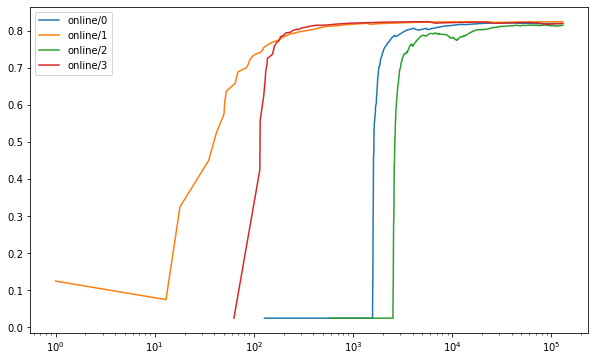

In [4]:
plot_action_perf(events_df, means)

r_mean = 0.816070556640625


<AxesSubplot:>

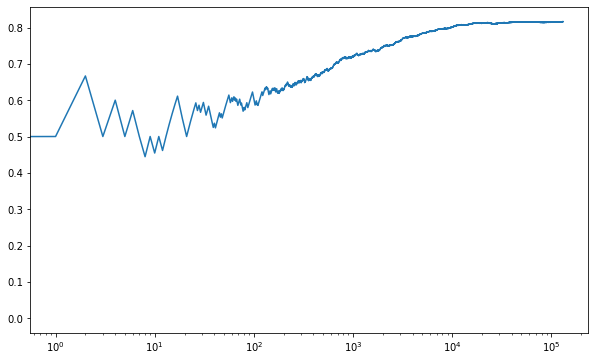

In [5]:
print(f'r_mean = {events_df["r"].mean()}')
events_df['r'].expanding().mean().plot(figsize=(10,6), logx=True)

In [6]:
vw_args='--cb_explore_adf --dsjson --epsilon 0 --coin --power_t 0 --quiet --cb_type mtr -q ::'

step1 = cfe(vw_args, events, env, steps_gen([1]), np.mean, '1-step', with_episode_length=False)

step2mean = cfe(vw_args, events, env, steps_gen([2]), np.mean, '2-step.mean', with_episode_length=False)
step2sum = cfe(vw_args, events, env, steps_gen([2]), np.sum, '2-step.sum', with_episode_length=False)

In [7]:
step4mean = cfe(vw_args, events, env, steps_gen([4]), np.mean, '4-step.mean', with_episode_length=False)
step4sum = cfe(vw_args, events, env, steps_gen([4]), np.sum, '4-step.sum', with_episode_length=False)

In [8]:
step8mean = cfe(vw_args, events, env, steps_gen([8]), np.mean, '8-step.mean', with_episode_length=False)
step8sum = cfe(vw_args, events, env, steps_gen([8]), np.sum, '8-step.sum', with_episode_length=False)

In [9]:
step16mean = cfe(vw_args, events, env, steps_gen([16]), np.mean, '16-step.mean', with_episode_length=False)
step16sum = cfe(vw_args, events, env, steps_gen([16]), np.sum, '16-step.sum', with_episode_length=False)

In [10]:
step2_8mean = cfe(vw_args, events, env, steps_gen([16]), np.mean, '2-8-step.mean', with_episode_length=False)
step2_8sum = cfe(vw_args, events, env, steps_gen([16]), np.sum, '2-8-step.sum', with_episode_length=False)

In [12]:
step2_8_el_mean = cfe(vw_args, events, env, steps_gen([16]), np.mean, '2-8-el-step.mean', with_episode_length=True)
step2_8_el_sum = cfe(vw_args, events, env, steps_gen([16]), np.sum, '2-8-el-step.sum', with_episode_length=True)

In [13]:
step2max = cfe(vw_args, events, env, steps_gen([2]), np.max, '2-step.max', with_episode_length=False)
step4max = cfe(vw_args, events, env, steps_gen([4]), np.max, '4-step.max', with_episode_length=False)
step8max = cfe(vw_args, events, env, steps_gen([8]), np.max, '8-step.max', with_episode_length=False)
step16max = cfe(vw_args, events, env, steps_gen([16]), np.max, '16-step.max', with_episode_length=False)

In [14]:
results = events_df.join(step1).join(step2mean).join(step2sum).join(step4mean).join(step4sum).join(step8mean).join(step8sum).join(step16mean).join(step16sum).join(step2_8mean).join(step2_8sum).join(step2_8_el_mean).join(step2_8_el_sum).join(step2max).join(step4max).join(step8max).join(step16max)

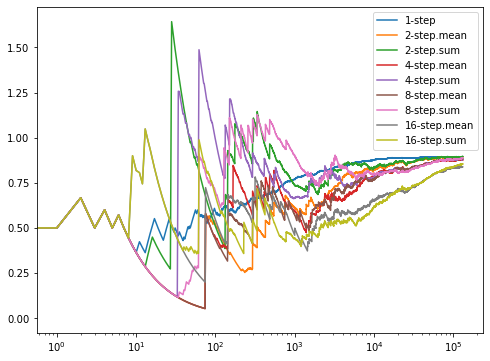

In [15]:
plot(results, ['1-step', '2-step.mean', '2-step.sum', '4-step.mean', '4-step.sum', '8-step.mean', '8-step.sum', '16-step.mean', '16-step.sum'])

# Setup arms configuration (8 people, 8 actions)

In [42]:
npeople = 8
narms = 8

means_8_8 = np.random.rand(npeople, narms)
print(f'Random perfomance: {np.mean(means)}')
print(f'Best performance: {np.max(means, axis=1).mean()}')
print(f'Best performance with 0.2 exploration: {np.max(means, axis=1).mean() * 0.8 + 0.2 * np.mean(means)}')

Random perfomance: 0.43828068663117514
Best performance: 0.8560902728344593
Best performance with 0.2 exploration: 0.7725283555938025


# Generate some data

In [44]:
vw_args='--cb_explore_adf --dsjson --epsilon 0.2 --coin --power_t 0 --quiet --cb_type mtr -q ::'

env_8_8 = environment(means_8_8)
events_8_8 = env.generate(vw_args, 1024 * 128)
events_8_8_df=pd.DataFrame(events_8_8)
events_8_8_df.head()

p  chosen  online  r
0  1       6   0.125  1
1  2       4   0.125  0
2  7       0   0.125  1
3  6       6   0.125  1
4  7       6   0.825  1

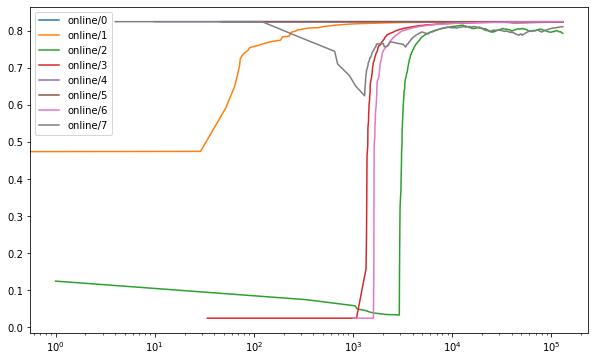

In [45]:
plot_action_perf(events_8_8_df, means)

r_mean = 0.767822265625


<AxesSubplot:>

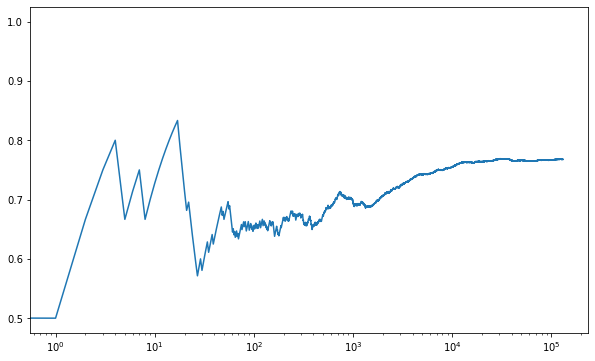

In [47]:
print(f'r_mean = {events_8_8_df["r"].mean()}')
events_8_8_df['r'].expanding().mean().plot(figsize=(10,6), logx=True)

In [50]:
vw_args='--cb_explore_adf --dsjson --epsilon 0 --coin --power_t 0 --quiet --cb_type mtr -q ::'

step1_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([1]), np.mean, '1-step', with_episode_length=False)

In [56]:
step2mean_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([2]), np.mean, '2-step.mean', with_episode_length=False)
step2sum_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([2]), np.sum, '2-step.sum', with_episode_length=False)
step2max_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([2]), np.max, '2-step.max', with_episode_length=False)

In [57]:
step4mean_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([4]), np.mean, '4-step.mean', with_episode_length=False)
step4sum_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([4]), np.sum, '4-step.sum', with_episode_length=False)
step4max_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([4]), np.max, '4-step.max', with_episode_length=False)

In [58]:
step8mean_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([8]), np.mean, '8-step.mean', with_episode_length=False)
step8sum_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([8]), np.sum, '8-step.sum', with_episode_length=False)
step8max_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([8]), np.max, '8-step.max', with_episode_length=False)

In [59]:
step16mean_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([16]), np.mean, '16-step.mean', with_episode_length=False)
step16sum_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([16]), np.sum, '16-step.sum', with_episode_length=False)
step16max_8_8 = cfe(vw_args, events_8_8, env_8_8, steps_gen([16]), np.max, '16-step.max', with_episode_length=False)

In [94]:
results_8_8 = events_8_8_df.join(step1_8_8).join(step2mean_8_8).join(step4mean_8_8).join(step8mean_8_8).join(step16mean_8_8).join(step2sum_8_8).join(step4sum_8_8).join(step8sum_8_8).join(step16sum_8_8).join(step2max_8_8).join(step4max_8_8).join(step8max_8_8).join(step16max_8_8)

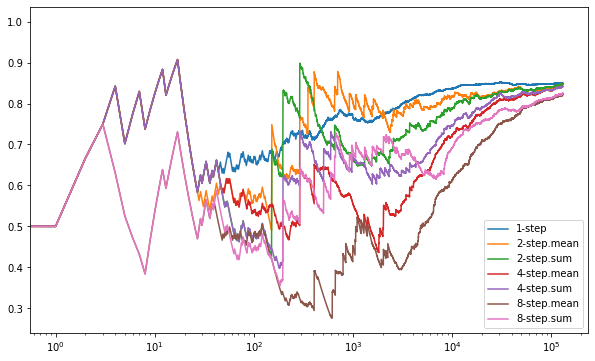

In [95]:
plot(results_8_8, ['1-step', '2-step.mean', '2-step.sum', '4-step.mean', '4-step.sum', '8-step.mean', '8-step.sum'])

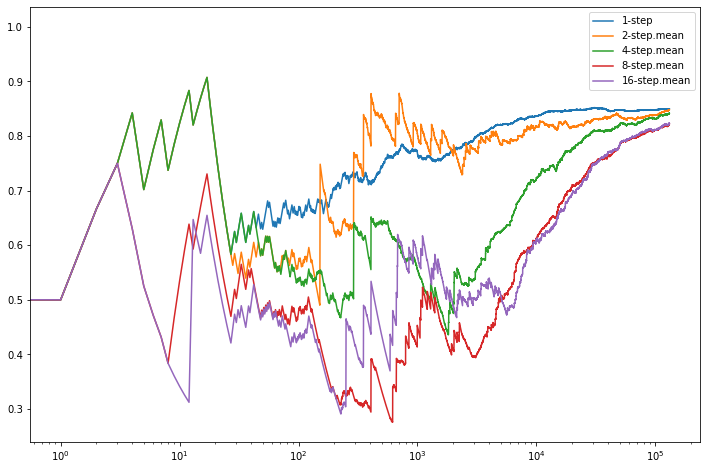

In [103]:
plot(results_8_8, ['1-step', '2-step.mean', '4-step.mean', '8-step.mean', '16-step.mean'])

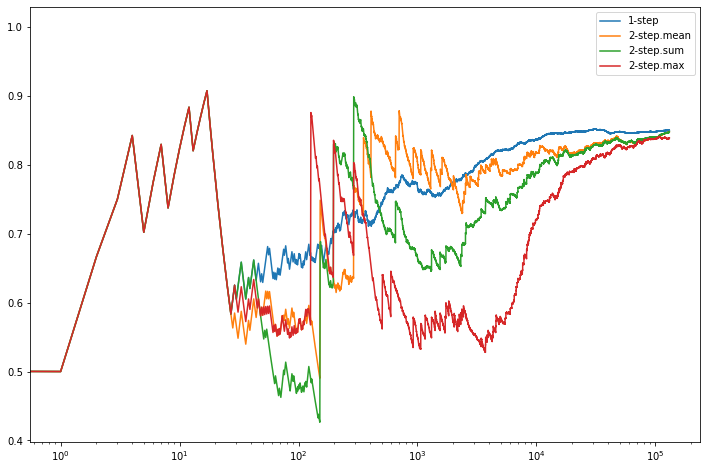

In [104]:
plot(results_8_8, ['1-step', '2-step.mean', '2-step.sum', '2-step.max'])

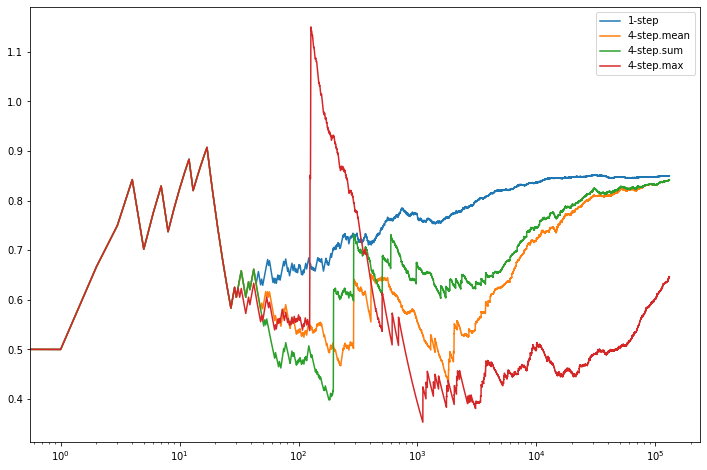

In [105]:
plot(results_8_8, ['1-step', '4-step.mean', '4-step.sum', '4-step.max'])

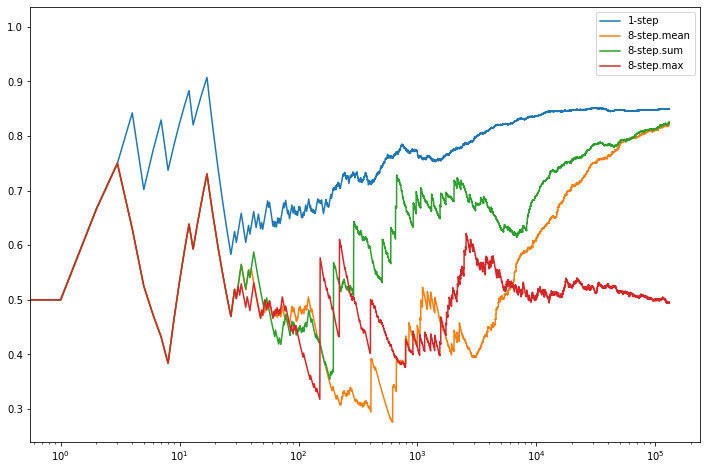

In [106]:
plot(results_8_8, ['1-step', '8-step.mean', '8-step.sum', '8-step.max'])

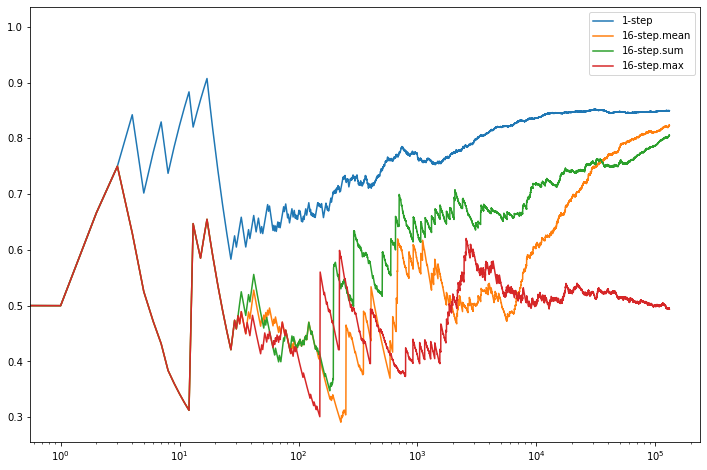

In [107]:
plot(results_8_8, ['1-step', '16-step.mean', '16-step.sum', '16-step.max'])

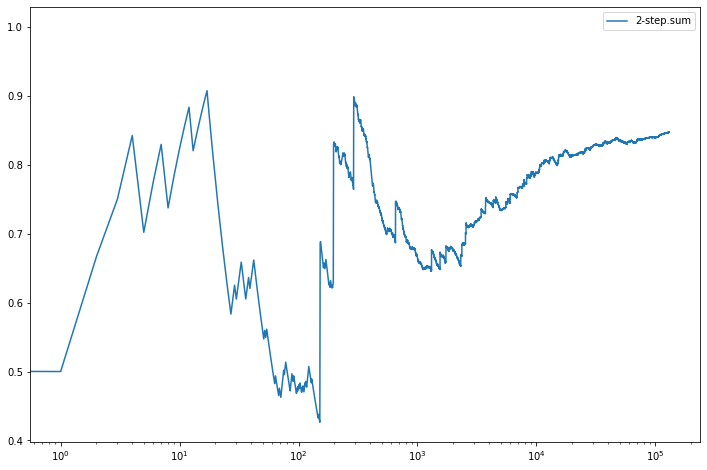

In [108]:
plot(results_8_8, ['2-step.sum'])

# Generate some data (epsilon / |episode|)

## |episode| = 2

In [109]:
vw_args_01='--cb_explore_adf --dsjson --epsilon 0.1 --coin --power_t 0 --quiet --cb_type mtr -q ::'

env_8_8_01 = environment(means_8_8)
events_8_8_01 = env.generate(vw_args_01, 1024 * 128)
events_8_8_01_df=pd.DataFrame(events_8_8_01)
events_8_8_01_df.head()

p  chosen  online  r
0  2       2   0.125  0
1  2       2   0.125  0
2  1       6   0.125  1
3  7       1   0.125  0
4  4       5   0.125  1

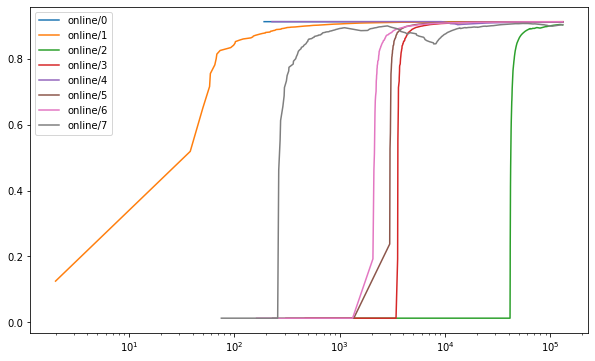

In [110]:
plot_action_perf(events_8_8_01_df, means)

r_mean = 0.8045806884765625


<AxesSubplot:>

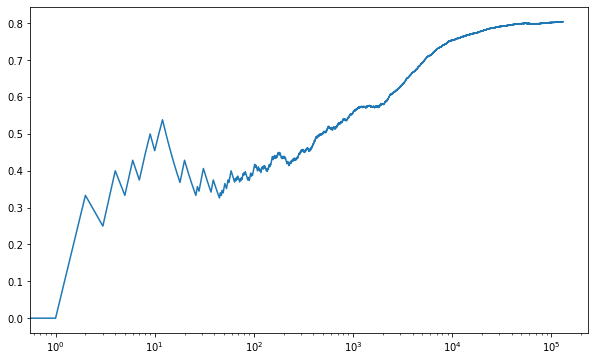

In [111]:
print(f'r_mean = {events_8_8_01_df["r"].mean()}')
events_8_8_01_df['r'].expanding().mean().plot(figsize=(10,6), logx=True)

In [139]:
vw_args='--cb_explore_adf --dsjson --epsilon 0 --coin --power_t 0 --quiet --cb_type mtr -q ::'

step1_8_8_0025 = cfe(vw_args, events_8_8_0025, env, steps_gen([1]), np.mean, '1-step-eps0.025', with_episode_length=False)

In [143]:
step8mean_8_8_0025 = cfe(vw_args, events_8_8_0025, env, steps_gen([8]), np.mean, '8-step-eps0.025.mean', with_episode_length=False)
step8sum_8_8_0025 = cfe(vw_args, events_8_8_0025, env, steps_gen([8]), np.sum, '8-step-eps0.025.sum', with_episode_length=False)

In [146]:
results_8_8_0025 = events_8_8_0025_df.join(step1_8_8_0025).join(step8mean_8_8_0025).join(step8sum_8_8_0025)

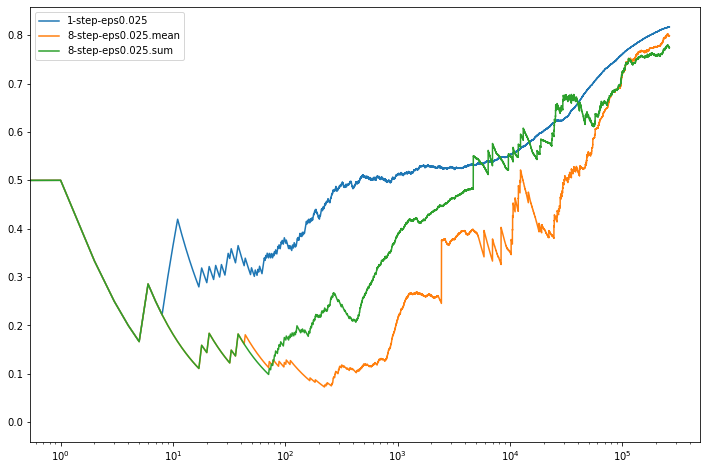

In [147]:
plot(results_8_8_0025, ['1-step-eps0.025', '8-step-eps0.025.mean', '8-step-eps0.025.sum'])

## |episode|=8

In [136]:
vw_args_0025='--cb_explore_adf --dsjson --epsilon 0.025 --coin --power_t 0 --quiet --cb_type mtr -q ::'

events_8_8_0025 = env.generate(vw_args_0025, 1024 * 256)
events_8_8_0025_df=pd.DataFrame(events_8_8_0025)
events_8_8_0025_df.head()

p  chosen  online  r
0  5       0   0.125  0
1  3       1   0.125  1
2  1       5   0.125  0
3  4       7   0.125  0
4  2       6   0.125  0

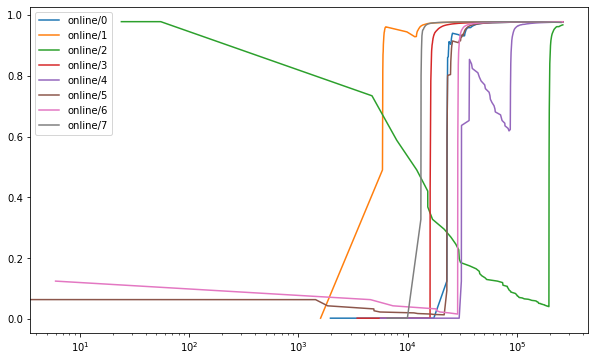

In [137]:
plot_action_perf(events_8_8_0025_df, means)

r_mean = 0.8072967529296875


<AxesSubplot:>

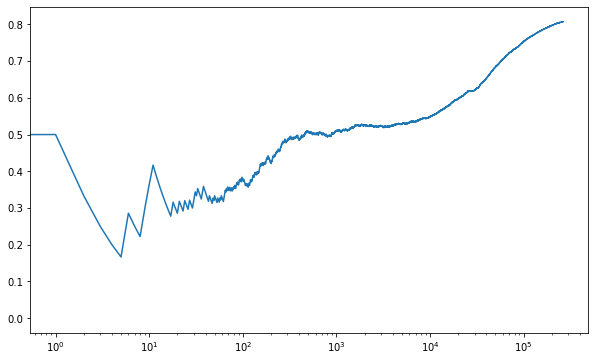

In [138]:
print(f'r_mean = {events_8_8_0025_df["r"].mean()}')
events_8_8_0025_df['r'].expanding().mean().plot(figsize=(10,6), logx=True)

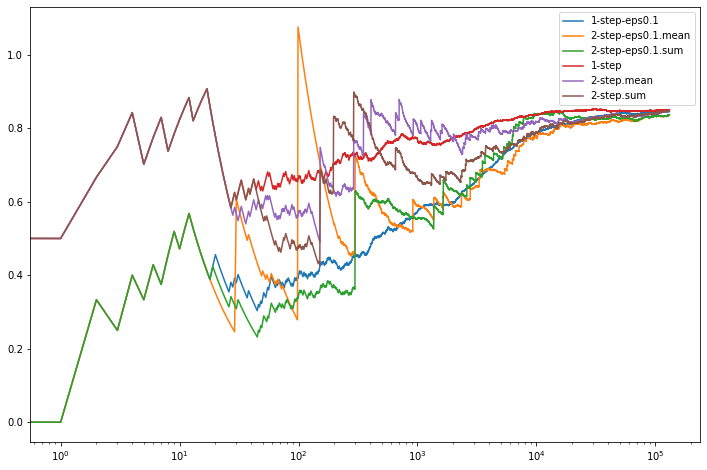

In [132]:
plot(results_8_8_01, ['1-step-eps0.1', '2-step-eps0.1.mean', '2-step-eps0.1.sum'])
plot(results_8_8, ['1-step', '2-step.mean', '2-step.sum'])